本段代码在于比较是否患有遗传病时DNA甲基化差异

In [1]:
#检测GPU可用性
import tensorflow as tf
print('GPU可用性:',tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU可用性: True


数据读取

In [2]:
#数据读取
import numpy as np
import pandas as pd
#本次取50000条数据
chunks=50000
traindata = pd.read_csv('/mnt/workspace/Data/train_dataset/traindata.csv', nrows=chunks)    #读取训练集
trainmap = pd.read_csv('/mnt/workspace/Data/train_dataset/trainmap.csv')

In [3]:
#获取基因ID
CG_ID=traindata.iloc[:chunks,0]

In [4]:
#数据预处理函数
#预处理训练集
traindata = traindata.set_index('cpgsite')
traindata = traindata.T
traindata = traindata.reset_index()
traindata = traindata.rename(columns={'index':'sample_id'})
traindata.columns = ['sample_id'] + [i for i in range(chunks)]

In [5]:
traindata.to_pickle('/mnt/workspace/Disease_class/ClassDataPkl/ClassData.pkl')    #输出为Pkl文件

In [6]:
#加载预处理后的数据
trainmap = pd.read_csv('/mnt/workspace/Data/train_dataset/trainmap.csv')
traindata = pd.read_pickle('/mnt/workspace/Disease_class/ClassDataPkl/ClassData.pkl')

In [7]:
#拼接CG编号
CG_ID_str=['sample_id']+list(CG_ID)
traindata.columns=CG_ID_str
traindata.head(10)

sample_id  cg00050873  cg00212031  cg00213748  cg00214611  cg00455876   
0  train10001         NaN         NaN         NaN         NaN         NaN  \
1  train10002         NaN         NaN         NaN         NaN         NaN   
2  train10003         NaN         NaN         NaN         NaN         NaN   
3  train10004         NaN         NaN         NaN         NaN         NaN   
4  train10005    1.136022   -4.489850         NaN   -3.993781    1.312567   
5  train10006    1.423834   -9.210440    1.035353   -3.837361    1.288795   
6  train10007         NaN         NaN         NaN         NaN         NaN   
7  train10008    1.475799   -3.993781         NaN   -4.051632    1.475799   
8  train10009         NaN         NaN         NaN         NaN         NaN   
9  train10010    1.515914   -4.051632         NaN   -4.585271    1.174443   

   cg01707559  cg02004872  cg02011394  cg02050847  ...  cg19321603   
0         NaN         NaN         NaN         NaN  ...    3.374769  \
1         NaN         NaN         NaN         NaN  ...    2.511081   
2         NaN         NaN         NaN         NaN  ...    2.324893   
3   -1.398461         NaN         NaN         NaN  ...    3.543689   
4   -2.901295   -4.585271    2.804368    2.985388  ...    2.401172   
5   -3.100385   -5.093549    2.767818    1.848299  ...    2.300497   
6         NaN         NaN         NaN         NaN  ...    2.648415   
7   -3.314031   -4.807960    2.785946    2.196336  ...    2.496772   
8         NaN         NaN         NaN         NaN  ...    2.218738   
9   -2.681278   -4.112908    3.406479    2.069693  ...    2.196336   

   cg19326232  cg19331040  cg19342109  cg19343088  cg19343809  cg19348622   
0   -5.492861   -3.201956   -2.414368   -2.698069   -2.942546   -4.402578  \
1   -4.247583   -3.659672   -2.218738   -2.823096   -2.804368   -3.175661   
2   -4.585271   -3.343970   -2.288480   -2.767818   -2.767818   -3.701353   
3   -4.940737   -3.314031   -2.585369   -3.007447   -4.247583   -2.861514   
4   -4.489850   -3.228904   -2.312634   -2.963760   -2.963760   -3.507691   
5   -4.247583   -3.284902   -2.131436   -3.100385   -3.149987   -3.744756   
6   -4.178048   -3.938986   -2.511081   -3.149987   -2.985388   -3.543689   
7   -5.093549   -3.314031   -2.585369   -3.007447   -2.749976   -3.837361   
8   -4.807960   -2.942546   -2.427712   -2.861514   -2.963760   -3.472874   
9   -3.659672   -3.175661   -2.100192   -2.804368   -2.749976   -3.701353   

   cg19349217  cg19349369  cg19350197  
0   -3.201956   -1.185564    2.253116  
1   -3.659672   -1.765757    2.511081  
2   -2.454856   -1.213659    1.765757  
3   -2.942546   -1.856830    2.207487  
4   -4.247583   -1.749816    2.264792  
5   -3.201956   -1.294708    2.185284  
6   -3.406479   -1.703036    2.767818  
7   -3.790034   -0.699002    2.468664  
8   -2.881228   -1.865415    2.570129  
9   -3.007447   -1.749816    2.163468  

[10 rows x 50001 columns]

数据预处理

In [8]:
#统计数据空缺值
traindata_null=traindata.isnull().sum().sum()    #统计前4万个特征缺失值
data_sum=traindata.shape[0]*traindata.shape[1]
traindata_null_rate=traindata_null/data_sum    #计算特征缺失率
print('训练数据缺失数据量为:{0},数据总量为:{1}'.format(traindata_null,data_sum))
print('训练数据缺失率为:{0}%'.format(round(traindata_null_rate*100,4)))

训练数据缺失数据量为:23688484,数据总量为:411658233
训练数据缺失率为:5.7544%


In [9]:
#缺失数据处理
traindata.fillna(0,inplace=True)    #训练集预处理

In [10]:
print(traindata.isnull().sum().sum())    #检验数据填充效果

0


In [11]:
# 拼接数据集
traindata = traindata.merge(trainmap[['sample_id', 'age', 'gender', 'sample_type', 'disease']],on='sample_id',how='left')

In [12]:
#统计数据中患病数据和患病数据汇总
sample_type_sum=traindata['sample_type'].value_counts()    #统计患病数据总量
print('-----------------患病数据总量----------------')
print(sample_type_sum)
disease_sum=traindata['disease'].value_counts()    #汇总患病数据
print('-----------------患病数据汇总----------------')
print(disease_sum)

-----------------患病数据总量----------------
sample_type
control           6266
disease tissue    1967
Name: count, dtype: int64
-----------------患病数据汇总----------------
disease
control                 6266
Alzheimer's disease      737
schizophrenia            381
Parkinson's disease      266
rheumatoid arthritis     159
stroke                   147
Huntington's disease     135
Graves' disease           58
type 2 diabetes           46
Sjogren's syndrome        38
Name: count, dtype: int64


In [13]:
#数据类型转化
disease_mapping = {
    'control': 0,
    "Alzheimer's disease": 1,
    "Graves' disease": 2,
    "Huntington's disease": 3,
    "Parkinson's disease": 4,
    'rheumatoid arthritis': 5,
    'schizophrenia': 6,
    "Sjogren's syndrome": 7,
    'stroke': 8,
    'type 2 diabetes': 9
}    #构建数据对应关系
sample_type_mapping = {'control': 0, 'disease tissue': 1}
gender_mapping = {'F': 0, 'M': 1}
#训练集转化
traindata['disease_encode'] = traindata['disease'].map(disease_mapping)
traindata['sample_type_encode'] = traindata['sample_type'].map(sample_type_mapping)
traindata['gender_encode'] = traindata['gender'].map(gender_mapping)

In [14]:
traindata.head(10)

sample_id  cg00050873  cg00212031  cg00213748  cg00214611  cg00455876   
0  train10001    0.000000    0.000000    0.000000    0.000000    0.000000  \
1  train10002    0.000000    0.000000    0.000000    0.000000    0.000000   
2  train10003    0.000000    0.000000    0.000000    0.000000    0.000000   
3  train10004    0.000000    0.000000    0.000000    0.000000    0.000000   
4  train10005    1.136022   -4.489850    0.000000   -3.993781    1.312567   
5  train10006    1.423834   -9.210440    1.035353   -3.837361    1.288795   
6  train10007    0.000000    0.000000    0.000000    0.000000    0.000000   
7  train10008    1.475799   -3.993781    0.000000   -4.051632    1.475799   
8  train10009    0.000000    0.000000    0.000000    0.000000    0.000000   
9  train10010    1.515914   -4.051632    0.000000   -4.585271    1.174443   

   cg01707559  cg02004872  cg02011394  cg02050847  ...  cg19349217   
0    0.000000    0.000000    0.000000    0.000000  ...   -3.201956  \
1    0.000000    0.000000    0.000000    0.000000  ...   -3.659672   
2    0.000000    0.000000    0.000000    0.000000  ...   -2.454856   
3   -1.398461    0.000000    0.000000    0.000000  ...   -2.942546   
4   -2.901295   -4.585271    2.804368    2.985388  ...   -4.247583   
5   -3.100385   -5.093549    2.767818    1.848299  ...   -3.201956   
6    0.000000    0.000000    0.000000    0.000000  ...   -3.406479   
7   -3.314031   -4.807960    2.785946    2.196336  ...   -3.790034   
8    0.000000    0.000000    0.000000    0.000000  ...   -2.881228   
9   -2.681278   -4.112908    3.406479    2.069693  ...   -3.007447   

   cg19349369  cg19350197   age  gender     sample_type              disease   
0   -1.185564    2.253116  88.0       F  disease tissue  Alzheimer's disease  \
1   -1.765757    2.511081  92.0       F  disease tissue  Alzheimer's disease   
2   -1.213659    1.765757  93.0       F  disease tissue  Alzheimer's disease   
3   -1.856830    2.207487  96.0       F  disease tissue  Alzheimer's disease   
4   -1.749816    2.264792  91.0       M  disease tissue  Alzheimer's disease   
5   -1.294708    2.185284  80.0       M  disease tissue  Alzheimer's disease   
6   -1.703036    2.767818  79.0       F  disease tissue  Alzheimer's disease   
7   -0.699002    2.468664  77.0       M  disease tissue  Alzheimer's disease   
8   -1.865415    2.570129  85.0       F  disease tissue  Alzheimer's disease   
9   -1.749816    2.163468  80.0       M  disease tissue  Alzheimer's disease   

   disease_encode  sample_type_encode  gender_encode  
0               1                   1            0.0  
1               1                   1            0.0  
2               1                   1            0.0  
3               1                   1            0.0  
4               1                   1            1.0  
5               1                   1            1.0  
6               1                   1            0.0  
7               1                   1            1.0  
8               1                   1            0.0  
9               1                   1            1.0  

[10 rows x 50008 columns]

数据划分和特征选择

In [15]:
#数据集切分
DataClass=traindata.iloc[:,1:-7]    #获取甲基化数据
DiseaseType=traindata.loc[:,'sample_type_encode']    #获取疾病类别数据
print('----------------DNA甲基化数据摘要-----------------')
print(DataClass.info())
print('----------------疾病数据摘要-----------------')
print(DiseaseType.info())

----------------DNA甲基化数据摘要-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8233 entries, 0 to 8232
Columns: 50000 entries, cg00050873 to cg19350197
dtypes: float64(50000)
memory usage: 3.1 GB
None
----------------疾病数据摘要-----------------
<class 'pandas.core.series.Series'>
RangeIndex: 8233 entries, 0 to 8232
Series name: sample_type_encode
Non-Null Count  Dtype
--------------  -----
8233 non-null   int64
dtypes: int64(1)
memory usage: 64.4 KB
None


In [16]:
#低方差滤过策略
from sklearn.feature_selection import VarianceThreshold
Variance_Threshold=VarianceThreshold(threshold=0.5)
Variance_Threshold.fit(DataClass)
print('剩余特征个数:',len(Variance_Threshold.get_support(True)))

剩余特征个数: 30135


In [17]:
#数据整理
from pandas import DataFrame
DataClass=Variance_Threshold.transform(DataClass)    #数据集转化
DataClass=DataFrame(DataClass)
DataClass.columns=Variance_Threshold.get_feature_names_out()

In [18]:
#高相关过滤法，基于F分布
from sklearn.feature_selection import SelectKBest,f_classif
KBest=SelectKBest(score_func=f_classif,k=10000)    #获取高相关的前100000个特征
KBest.fit(DataClass,DiseaseType)
from pandas import DataFrame
Score_DF=DataFrame()
Score_DF['feature']=DataFrame(DataClass).columns    #特征命
Score_DF['Score']=KBest.scores_    #相关系数
Score_DF['P-value']=KBest.pvalues_    #P值
Score_DF=Score_DF.sort_values('Score',ascending=False)

In [19]:
Score_DF.head(20)    #查看高相关过滤法数据

feature        Score        P-value
8904   cg22153728  1022.176079  1.575598e-211
11302  cg04667538   974.107682  3.279602e-202
6322   cg12728588   962.280597  6.548009e-200
17958  cg18026197   943.530347  2.944679e-196
13540  cg16179507   934.507814  1.696285e-194
3719   cg03126058   927.766804  3.515086e-193
8438   cg20263392   916.043339  6.882087e-191
29100  cg14296274   898.940297  1.536288e-187
20203  cg08758887   884.238524  1.175259e-184
9664   cg24674680   873.272000  1.675770e-182
5569   cg09993145   867.540370  2.244320e-181
6281   cg12611488   859.830609  7.379053e-180
22858  cg02453726   857.984512  1.703799e-179
6920   cg15007228   854.705909  7.533893e-179
26831  cg03068319   853.462510  1.324107e-178
7907   cg18128887   852.445657  2.100055e-178
23907  cg10616795   850.325314  5.495228e-178
7965   cg18232828   846.067988  3.793783e-177
22542  cg00409126   836.850633  2.495223e-175
23806  cg09660894   836.267623  3.252113e-175

In [20]:
#数据拼接
DataClass=KBest.transform(DataClass)
DataClass=DataFrame(DataClass)
DataClass.columns=KBest.get_feature_names_out()

In [21]:
#数据样本正态性检验
from scipy.stats import normaltest
for cg in DataClass.columns:
    cg_data=DataClass.loc[:,cg]    #获取cg数据
    NormalStats,p_value=normaltest(cg_data)     #正态检验
    if p_value>=0.05:
        print('甲基化位点:{0},正态检验结果:{1},P值:{2}'.format(cg,NormalStats,p_value))

甲基化位点:cg00425885,正态检验结果:4.985875627771477,P值:0.0826667499616028
甲基化位点:cg04158367,正态检验结果:2.9654561771258137,P值:0.22701751893287192
甲基化位点:cg08928753,正态检验结果:1.275617118757193,P值:0.5284492211435821
甲基化位点:cg09154356,正态检验结果:4.815128587611353,P值:0.09003432488003488
甲基化位点:cg15198247,正态检验结果:2.8123940118438835,P值:0.2450735263469884
甲基化位点:cg18236877,正态检验结果:2.1216567622323197,P值:0.3461689317180136
甲基化位点:cg19827875,正态检验结果:0.641432390561573,P值:0.7256291587496142
甲基化位点:cg26907438,正态检验结果:1.0417861081558337,P值:0.5939898459784846
甲基化位点:cg01089914,正态检验结果:2.0895931642679137,P值:0.35176336705426064
甲基化位点:cg25168494,正态检验结果:3.8727230013639273,P值:0.14422776888080377
甲基化位点:cg27091865,正态检验结果:0.5015495971537929,P值:0.7781976030346871
甲基化位点:cg07100595,正态检验结果:0.49643893390160276,P值:0.7801886988526888
甲基化位点:cg17482033,正态检验结果:3.1389137204432873,P值:0.20815821066356002
甲基化位点:cg10957242,正态检验结果:1.6464306836946887,P值:0.43901779042264133
甲基化位点:cg11566977,正态检验结果:4.398080308226628,P值:0.11090956337615789
甲基化位点:cg11214757,正态检验结

查看数据标签分布
sample_type_encode
0    6266
1    1967
Name: count, dtype: int64


/tmp/ipykernel_2047/4102924553.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(DiseaseType,hist=True,rug=True,kde=False)


<Axes: xlabel='sample_type_encode'>

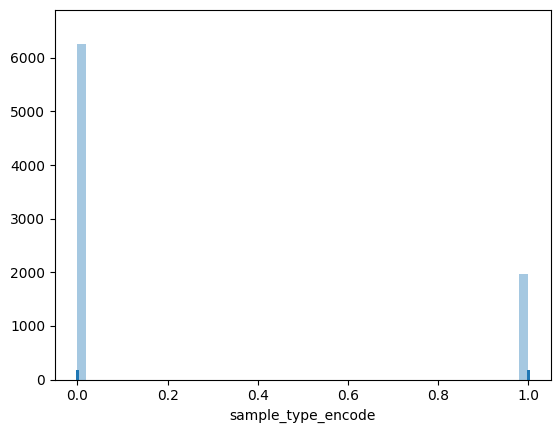

In [22]:
#查看数据标签分布
print('查看数据标签分布')
print(DiseaseType.value_counts())
import seaborn as sns
sns.distplot(DiseaseType,hist=True,rug=True,kde=False)

In [23]:
#划分数据集
from sklearn.model_selection import train_test_split
DataClass['Gender']=traindata.loc[:,'gender_encode']    #接入性别数据
Data_train_class,Data_test_class,Label_train_class,Label_test_class=train_test_split(DataClass,DiseaseType,train_size=0.8,random_state=123)
print('训练集数据规模为:{0},测试集数据规模为:{1}'.format(Data_train_class.shape,Data_test_class.shape))
print('训练集标签规模为:{0},测试集标签规模为:{1}'.format(Label_train_class.shape,Label_test_class.shape)) 

训练集数据规模为:(6586, 10001),测试集数据规模为:(1647, 10001)
训练集标签规模为:(6586,),测试集标签规模为:(1647,)


In [24]:
#查看数据标签分布
print('-------------训练数据集------------------')
print(Label_train_class.value_counts())
print('-------------测试数据集------------------')
print(Label_test_class.value_counts())

-------------训练数据集------------------
sample_type_encode
0    4992
1    1594
Name: count, dtype: int64
-------------测试数据集------------------
sample_type_encode
0    1274
1     373
Name: count, dtype: int64


模型训练:采用XGBoost、LightGBM、CatBoost和SVM模型

In [25]:
#加载并训练XGBoost模型
import xgboost
Model_XGB_Class=xgboost.XGBClassifier(booster='gbtree',n_estimators=1000,max_depth=2,gpu_id=0, n_jobs=-1,tree_method='gpu_hist')
Model_XGB_Class.fit(Data_train_class,Label_train_class) 

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [26]:
#模型测量
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,classification_report
def Model_Evaluate(model,X_train,y_train,X_test,y_test):
    train_pred=model.predict(X_train)    #训练误差测定
    precision_train=precision_score(y_train,train_pred,average='micro')
    recall_train=recall_score(y_train,train_pred,average='micro')
    f1_train=f1_score(y_train,train_pred,average='micro')
    accuracy_train=accuracy_score(y_train,train_pred)
    print('模型训练准确率为:{0},召回率为:{1},f1分数为:{2},精度为:{3}'.format(precision_train,recall_train,f1_train,accuracy_train))
    test_pred=model.predict(X_test)    #测试误差测定
    precision_test=precision_score(y_test,test_pred,average='micro')
    recall_test=recall_score(y_test,test_pred,average='micro')
    f1_test=f1_score(y_test,test_pred,average='micro')
    accuracy_test=accuracy_score(y_test,test_pred)
    print('模型测试准确率为:{0},召回率为:{1},f1分数为:{2},精度为:{3}'.format(precision_test,recall_test,f1_test,accuracy_test))
    train_err=1-model.score(X_train,y_train)
    test_err=1-model.score(X_test,y_test)
    print('模型训练误差:{0},测试误差:{1}'.format(train_err,test_err))
    print('---------------------训练数据集评估报告---------------------')
    print(classification_report(y_train,train_pred))
    print('---------------------测试数据集评估报告---------------------')
    print(classification_report(y_test,test_pred))
Model_Evaluate(Model_XGB_Class, Data_train_class,Label_train_class, Data_test_class,Label_test_class)

模型训练准确率为:0.991041603401154,召回率为:0.991041603401154,f1分数为:0.991041603401154,精度为:0.991041603401154
模型测试准确率为:0.8670309653916212,召回率为:0.8670309653916212,f1分数为:0.8670309653916212,精度为:0.8670309653916212
模型训练误差:0.008958396598846008,测试误差:0.13296903460837883
---------------------训练数据集评估报告---------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4992
           1       0.99      0.97      0.98      1594

    accuracy                           0.99      6586
   macro avg       0.99      0.99      0.99      6586
weighted avg       0.99      0.99      0.99      6586

---------------------测试数据集评估报告---------------------
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1274
           1       0.72      0.67      0.70       373

    accuracy                           0.87      1647
   macro avg       0.81      0.80      0.81      1647
weighted avg       0.86      0.87      0.87     

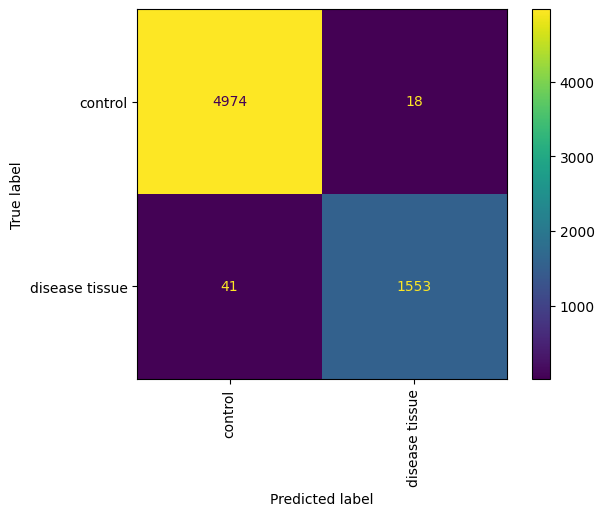

In [27]:
#可视化混淆矩阵
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
Label_class=['control','disease tissue']
def Viz_confusion_Matrix(model,X,y):
    y_pred=model.predict(X)
    con_matr=confusion_matrix(y, y_pred)
    con_matr=ConfusionMatrixDisplay(con_matr,display_labels=Label_class)
    con_matr.plot(include_values=True, cmap='viridis', xticks_rotation='horizontal', values_format='d', ax=None)
    con_matr.ax_.set_xticklabels(Label_class, rotation=90)  # 这里可以设置x轴标签的旋转角度 
    con_matr.ax_.set_yticklabels(Label_class, rotation=0)  # 这里可以设置y轴标签的旋转角度
Viz_confusion_Matrix(Model_XGB_Class, Data_train_class,Label_train_class)    #可视化Xgboost模型混淆矩阵(训练)

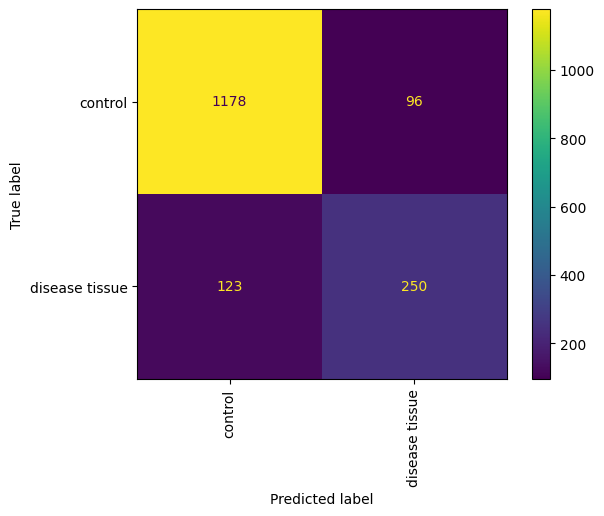

In [28]:
Viz_confusion_Matrix(Model_XGB_Class, Data_test_class,Label_test_class)    #可视化Xgboost模型混淆矩阵(测试)

<Axes: title={'center': 'Feature importance'}, xlabel='gain', ylabel='Features'>

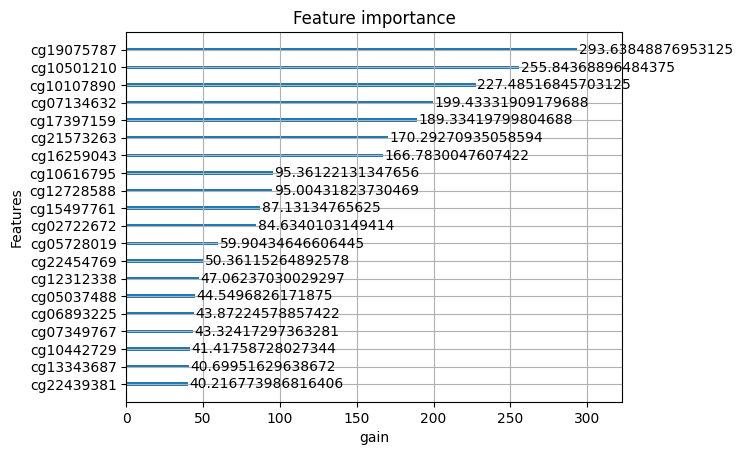

In [29]:
#提取贡献较大的前20个甲基化位点
from xgboost import plot_importance
plot_importance(Model_XGB_Class,max_num_features=20,importance_type='gain',xlabel='gain')    #可视化前20个甲基化位点数据

In [30]:
#保存模型
import joblib
joblib.dump(Model_XGB_Class,'/mnt/workspace/Disease_class/ClassModels_NvsD/Model_XGB_Class.pkl')
Model_XGB_Class.save_model('/mnt/workspace/Disease_class/ClassModels_NvsD/model_file_xgb_class.xgb')

In [ ]:
from lightgbm import LGBMClassifier
Model_LGB_Class=LGBMClassifier(subsample=0.5,colsample_bytree=0.5,n_jobs=-1)
Model_LGB_Class.fit(Data_train_class,Label_train_class)

In [32]:
Model_Evaluate(Model_LGB_Class, Data_train_class,Label_train_class, Data_test_class,Label_test_class)

模型训练准确率为:0.9904342544791983,召回率为:0.9904342544791983,f1分数为:0.9904342544791983,精度为:0.9904342544791983
模型测试准确率为:0.8664238008500303,召回率为:0.8664238008500303,f1分数为:0.8664238008500303,精度为:0.8664238008500303
模型训练误差:0.009565745520801694,测试误差:0.13357619914996965
---------------------训练数据集评估报告---------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4992
           1       0.99      0.97      0.98      1594

    accuracy                           0.99      6586
   macro avg       0.99      0.98      0.99      6586
weighted avg       0.99      0.99      0.99      6586

---------------------测试数据集评估报告---------------------
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1274
           1       0.74      0.63      0.68       373

    accuracy                           0.87      1647
   macro avg       0.82      0.78      0.80      1647
weighted avg       0.86      0.87      0.86 

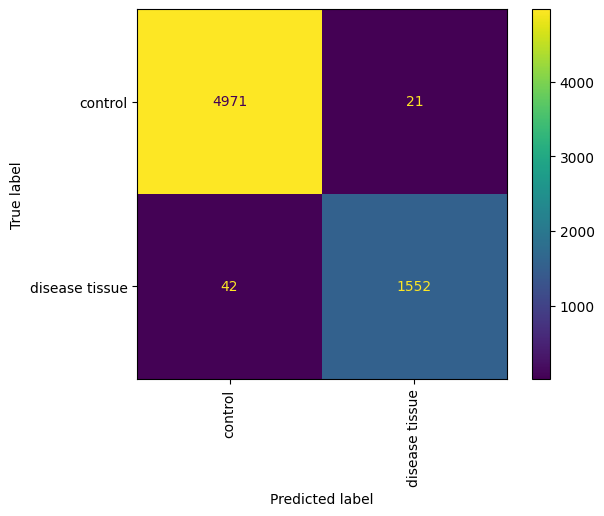

In [33]:
Viz_confusion_Matrix(Model_LGB_Class, Data_train_class,Label_train_class)    #可视化lightGM模型混淆矩阵(训练)

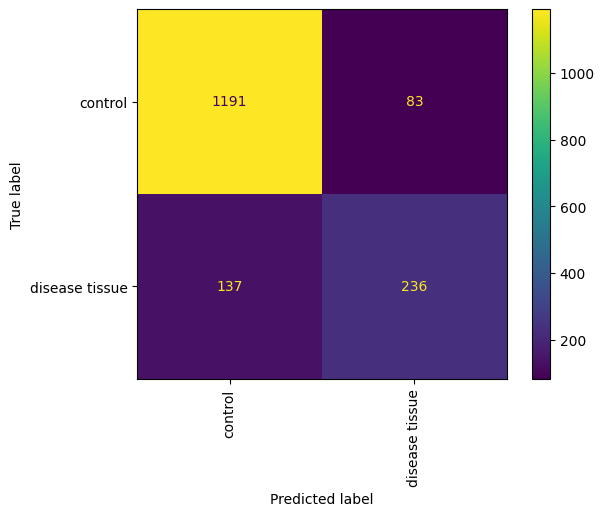

In [34]:
Viz_confusion_Matrix(Model_LGB_Class, Data_test_class,Label_test_class)    #可视化lightGM模型混淆矩阵(测试)

In [35]:
joblib.dump(Model_LGB_Class,'/mnt/workspace/Disease_class/ClassModels_NvsD/Model_LGB_Class.pkl')    #模型保存

['/mnt/workspace/Disease_class/ClassModels_NvsD/Model_LGB_Class.pkl']

<Axes: title={'center': 'Feature importance'}, xlabel='gain', ylabel='Features'>

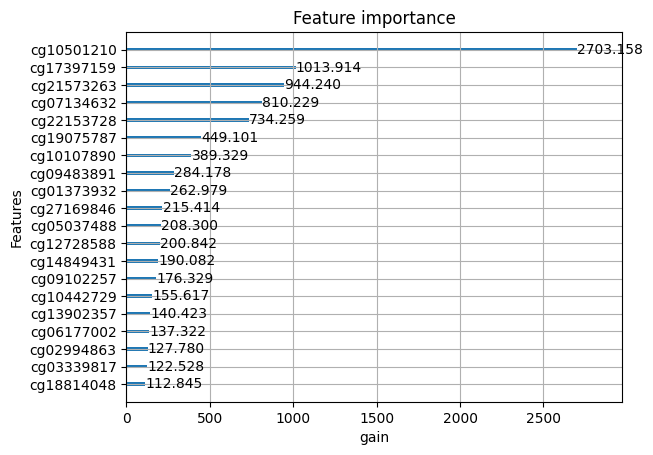

In [36]:
from lightgbm import plot_importance
plot_importance(Model_LGB_Class,max_num_features=20,importance_type='gain',xlabel='gain')    #可视化前20个甲基化位点

In [37]:
#训练catBoost模型
from catboost import CatBoostClassifier
Model_Cat=CatBoostClassifier(learning_rate=0.5, depth=3, bootstrap_type='Bernoulli',
                            random_seed=2023,od_type='Iter', od_wait=100)
Model_Cat.fit(Data_train_class,Label_train_class)

0:	learn: 0.5256146	total: 245ms	remaining: 4m 5s
1:	learn: 0.4573241	total: 409ms	remaining: 3m 23s
2:	learn: 0.4400545	total: 576ms	remaining: 3m 11s
3:	learn: 0.4253934	total: 740ms	remaining: 3m 4s
4:	learn: 0.4171354	total: 900ms	remaining: 2m 59s
5:	learn: 0.4106606	total: 1.06s	remaining: 2m 55s
6:	learn: 0.4041399	total: 1.22s	remaining: 2m 53s
7:	learn: 0.4002307	total: 1.38s	remaining: 2m 50s
8:	learn: 0.3961256	total: 1.53s	remaining: 2m 48s
9:	learn: 0.3930849	total: 1.69s	remaining: 2m 47s
10:	learn: 0.3907094	total: 1.84s	remaining: 2m 45s
11:	learn: 0.3882400	total: 2s	remaining: 2m 44s
12:	learn: 0.3846742	total: 2.15s	remaining: 2m 43s
13:	learn: 0.3797124	total: 2.31s	remaining: 2m 42s
14:	learn: 0.3779112	total: 2.46s	remaining: 2m 41s
15:	learn: 0.3754978	total: 2.61s	remaining: 2m 40s
16:	learn: 0.3726087	total: 2.77s	remaining: 2m 40s
17:	learn: 0.3671880	total: 2.93s	remaining: 2m 39s
18:	learn: 0.3640614	total: 3.09s	remaining: 2m 39s
19:	learn: 0.3607938	total:

In [38]:
Model_Evaluate(Model_Cat, Data_train_class,Label_train_class, Data_test_class,Label_test_class)

模型训练准确率为:0.9899787427877316,召回率为:0.9899787427877316,f1分数为:0.9899787427877316,精度为:0.9899787427877316
模型测试准确率为:0.856709168184578,召回率为:0.856709168184578,f1分数为:0.856709168184578,精度为:0.856709168184578
模型训练误差:0.01002125721226843,测试误差:0.14329083181542202
---------------------训练数据集评估报告---------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4992
           1       0.99      0.97      0.98      1594

    accuracy                           0.99      6586
   macro avg       0.99      0.98      0.99      6586
weighted avg       0.99      0.99      0.99      6586

---------------------测试数据集评估报告---------------------
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1274
           1       0.71      0.63      0.66       373

    accuracy                           0.86      1647
   macro avg       0.80      0.78      0.79      1647
weighted avg       0.85      0.86      0.85      

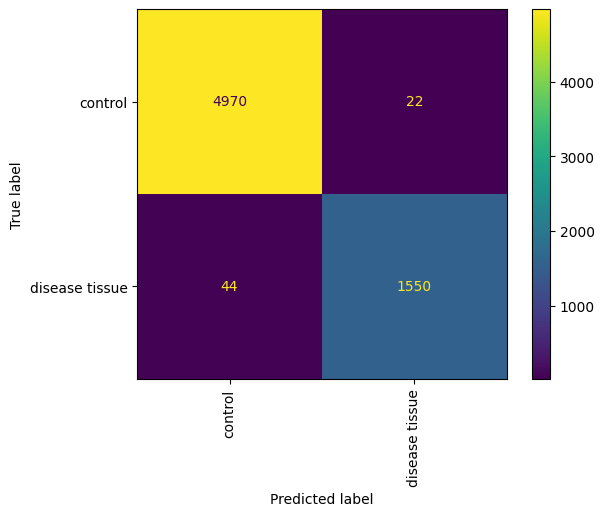

In [39]:
Viz_confusion_Matrix(Model_Cat, Data_train_class,Label_train_class)    #可视化CatBoost模型混淆矩阵(训练)

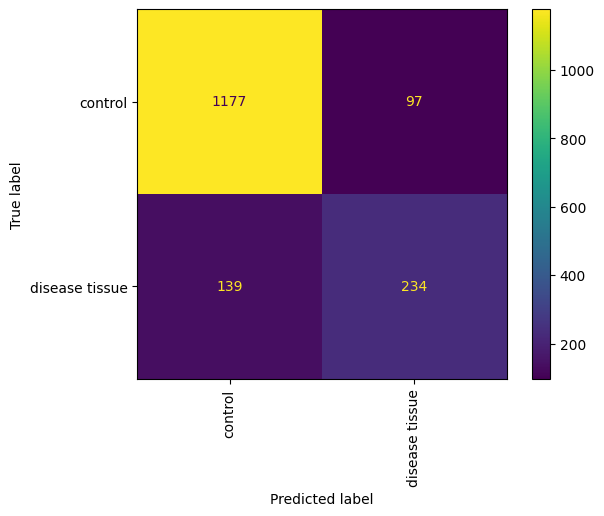

In [40]:
Viz_confusion_Matrix(Model_Cat, Data_test_class,Label_test_class)    #可视化CatBoost模型混淆矩阵(测试)

In [41]:
joblib.dump(Model_Cat,'/mnt/workspace/Disease_class/ClassModels_NvsD/Model_Cat_Class.pkl')

['/mnt/workspace/Disease_class/ClassModels_NvsD/Model_Cat_Class.pkl']

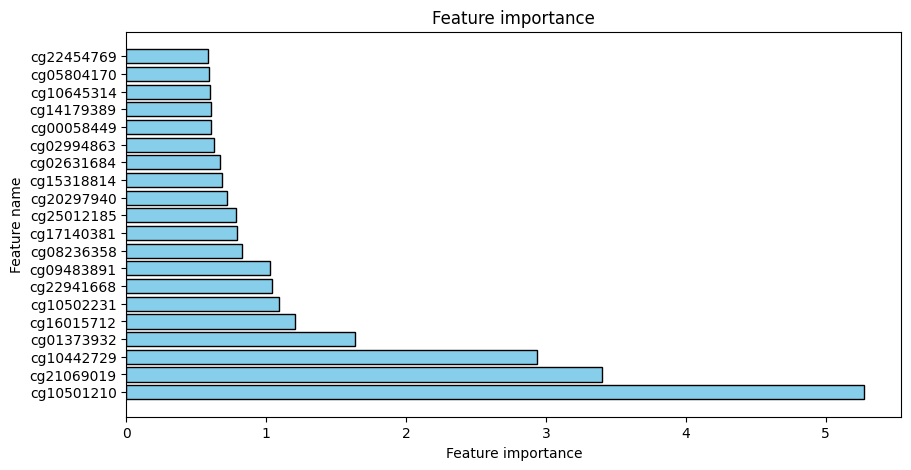

In [42]:
#绘制CatBoost模型特征重要性评分
Feature_importance_Cat=DataFrame()
Feature_importance_Cat['fearure names']=Data_train_class.columns    #特征列表
Feature_importance_Cat['fearure importance']=Model_Cat.get_feature_importance()    #特征重要性评分
Feature_importance_Cat=Feature_importance_Cat.sort_values('fearure importance',ascending=False)    #按照降序排序
# 绘制CatBoost模型特征重要性柱形图
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.title('Feature importance')
plt.barh(np.arange(1,21), Feature_importance_Cat.iloc[:20,1],color='skyblue', edgecolor='black')
plt.ylabel('Feature name')  
plt.xlabel('Feature importance')
plt.yticks(np.arange(1,21),Feature_importance_Cat.iloc[:20,0])
plt.show()

训练SVM模型

In [43]:
#填充数据
Data_train_class.fillna(0,inplace=True)
print('----------------训练数据空缺值统计----------------')
print(Data_train_class.isnull().sum())
Data_test_class.fillna(0,inplace=True)
print('----------------测试数据空缺值统计----------------')
print(Data_test_class.isnull().sum())

----------------训练数据空缺值统计----------------
cg03706273    0
cg04448376    0
cg10213302    0
cg10363397    0
cg11131351    0
             ..
cg19291355    0
cg19320816    0
cg19349369    0
cg19350197    0
Gender        0
Length: 10001, dtype: int64
----------------测试数据空缺值统计----------------
cg03706273    0
cg04448376    0
cg10213302    0
cg10363397    0
cg11131351    0
             ..
cg19291355    0
cg19320816    0
cg19349369    0
cg19350197    0
Gender        0
Length: 10001, dtype: int64


In [44]:
#载入SVM模型
from sklearn.svm import SVC
Model_SVC=SVC(kernel='rbf',C=1,probability=False)
Model_SVC.fit(Data_train_class,Label_train_class)
Model_Evaluate(Model_SVC, Data_train_class,Label_train_class, Data_test_class,Label_test_class)

模型训练准确率为:0.9899787427877316,召回率为:0.9899787427877316,f1分数为:0.9899787427877316,精度为:0.9899787427877316
模型测试准确率为:0.856709168184578,召回率为:0.856709168184578,f1分数为:0.856709168184578,精度为:0.856709168184578
模型训练误差:0.01002125721226843,测试误差:0.14329083181542202
---------------------训练数据集评估报告---------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4992
           1       0.99      0.97      0.98      1594

    accuracy                           0.99      6586
   macro avg       0.99      0.98      0.99      6586
weighted avg       0.99      0.99      0.99      6586

---------------------测试数据集评估报告---------------------
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1274
           1       0.71      0.63      0.66       373

    accuracy                           0.86      1647
   macro avg       0.80      0.78      0.79      1647
weighted avg       0.85      0.86      0.85      

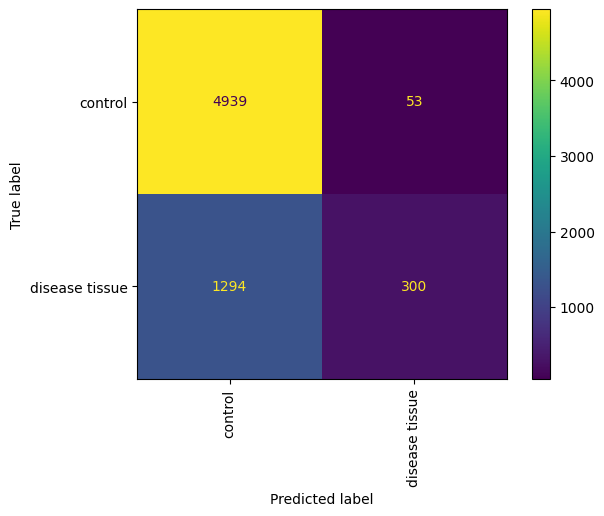

In [45]:
Viz_confusion_Matrix(Model_SVC, Data_train_class,Label_train_class)    #可视化CatBoost模型混淆矩阵(训练)

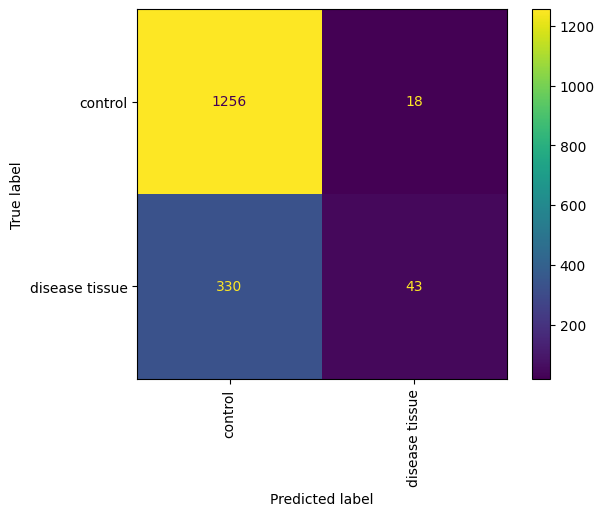

In [46]:
Viz_confusion_Matrix(Model_SVC, Data_test_class,Label_test_class)    #可视化CatBoost模型混淆矩阵(测试)

In [47]:
joblib.dump(Model_Cat,'/mnt/workspace/Disease_class/ClassModels_NvsD/Model_SVM_Class.pkl')

['/mnt/workspace/Disease_class/ClassModels_NvsD/Model_SVM_Class.pkl']

载入SHAP可解释器

In [48]:
from pandas import DataFrame
Feature_importance=DataFrame()
Feature_importance['fearure names']=Data_train_class.columns    #特征列表
Feature_importance['fearure importance']=Model_XGB_Class.feature_importances_    #特征重要性评分
Feature_importance=Feature_importance.sort_values('fearure importance',ascending=False)    #按照降序排序

In [49]:
Feature_list=list(Feature_importance.iloc[:20,0])
Feature_Data=DataClass.loc[:,Feature_list]
Feature_traindata,Feature_testdata,Feature_trainlabel,Feature_testlabel=train_test_split(Feature_Data,DiseaseType,train_size=0.8,random_state=123)
print('训练集数据规模为:{0},测试集数据规模为:{1}'.format(Feature_traindata.shape,Feature_testdata.shape))
print('训练集标签规模为:{0},测试集标签规模为:{1}'.format(Feature_trainlabel.shape,Feature_testlabel.shape)) 

训练集数据规模为:(6586, 20),测试集数据规模为:(1647, 20)
训练集标签规模为:(6586,),测试集标签规模为:(1647,)


In [50]:
#训练XGBoost模型
Feature_XGB=xgboost.XGBClassifier(booster='gbtree',n_estimators=800,max_depth=2,gpu_id=0, tree_method='gpu_hist')
Feature_XGB.fit(Feature_traindata,Feature_trainlabel)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=800, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [51]:
Model_Evaluate(Feature_XGB,Feature_traindata,Feature_trainlabel,Feature_testdata,Feature_testlabel)

模型训练准确率为:0.947616155481324,召回率为:0.947616155481324,f1分数为:0.947616155481324,精度为:0.947616155481324
模型测试准确率为:0.8427443837279903,召回率为:0.8427443837279903,f1分数为:0.8427443837279903,精度为:0.8427443837279903
模型训练误差:0.05238384451867595,测试误差:0.15725561627200968
---------------------训练数据集评估报告---------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      4992
           1       0.93      0.85      0.89      1594

    accuracy                           0.95      6586
   macro avg       0.94      0.91      0.93      6586
weighted avg       0.95      0.95      0.95      6586

---------------------测试数据集评估报告---------------------
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1274
           1       0.68      0.57      0.62       373

    accuracy                           0.84      1647
   macro avg       0.78      0.75      0.76      1647
weighted avg       0.84      0.84      0.84      

In [52]:
import shap
Explainer=shap.TreeExplainer(Feature_XGB)    #创建解释器
shap_values=Explainer.shap_values(Feature_traindata)    #计算训练shap值

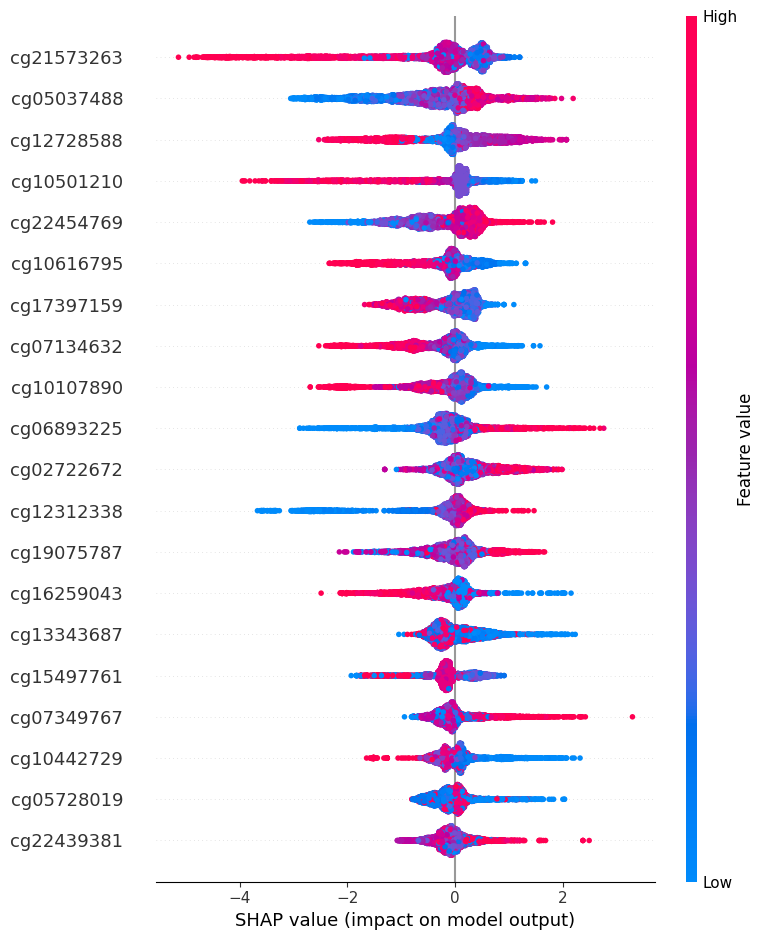

In [53]:
shap.summary_plot(shap_values,Feature_traindata)    #全局特征SHAP分布(训练)

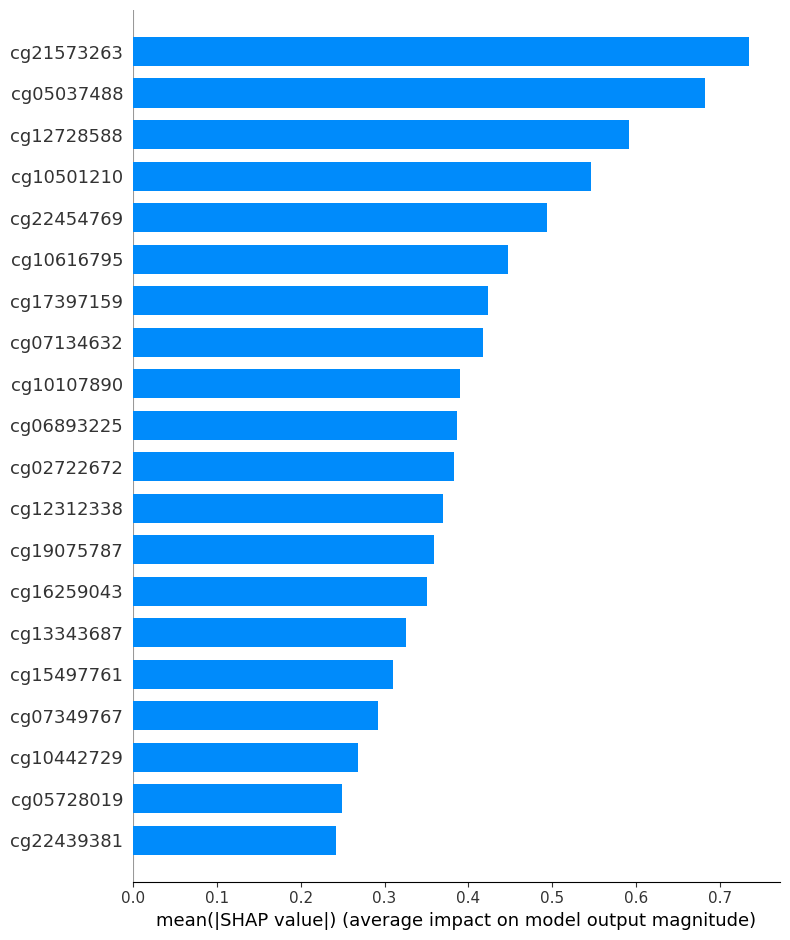

In [54]:
shap.summary_plot(shap_values,Feature_traindata,plot_type='bar')    #特征重要性堆叠图(训练)

In [55]:
Explainer_test=shap.TreeExplainer(Feature_XGB)    #创建解释器
shap_values_test=Explainer_test.shap_values(Feature_testdata)    #计算测试shap值

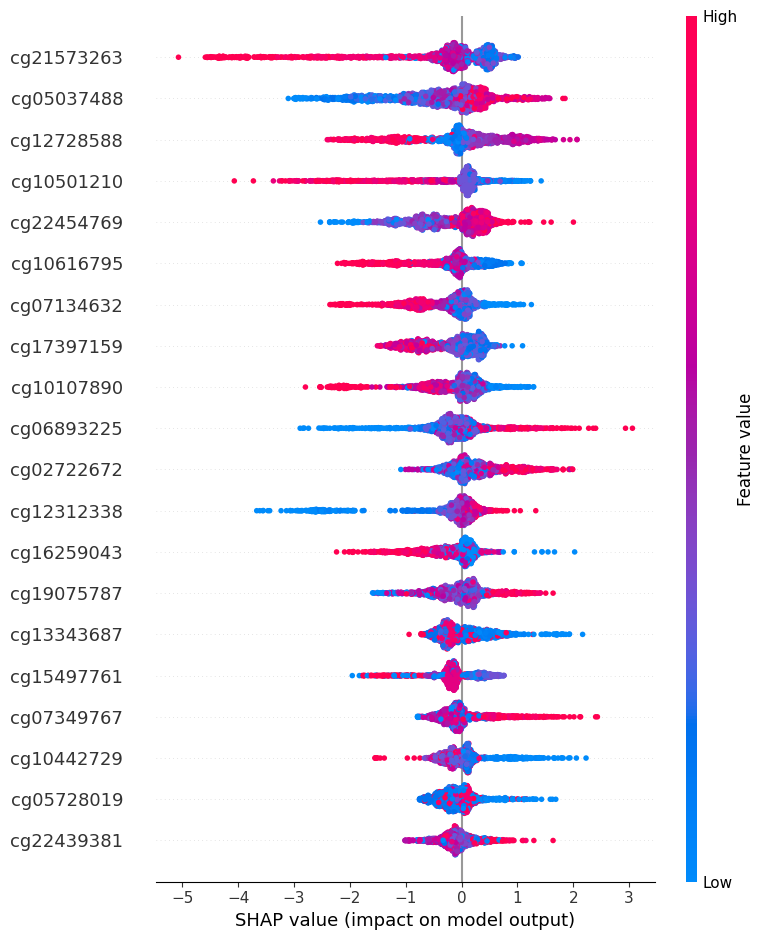

In [56]:
shap.summary_plot(shap_values_test,Feature_testdata)    #全局特征SHAP分布(测试)

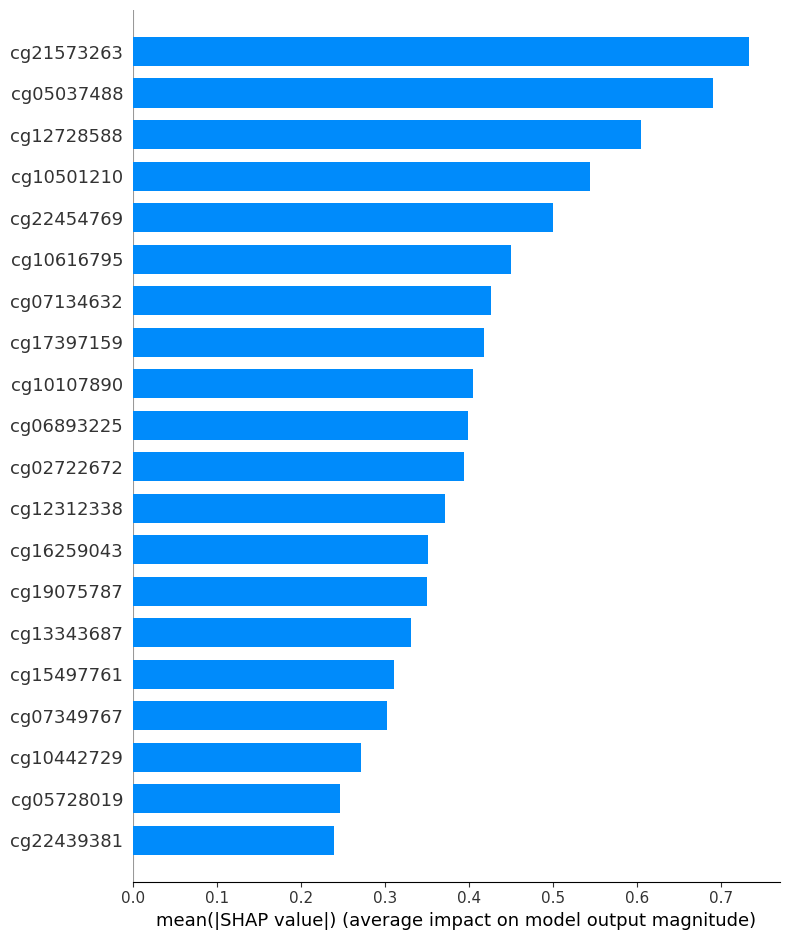

In [57]:
shap.summary_plot(shap_values_test,Feature_testdata,plot_type='bar')    #特征重要性堆叠图(测试)

In [58]:
#构建数据子集
Featute_Data=Feature_list+['gender','sample_type','disease','disease_encode','sample_type_encode','gender_encode']
ClassData=traindata.loc[:,Featute_Data]
ClassData.head(10)

cg19075787  cg10501210  cg10107890  cg07134632  cg17397159  cg21573263   
0   -2.648415   -3.100385   -1.954393   -1.330612   -1.891498    0.758205  \
1   -2.681278   -2.468664   -1.367282   -1.288795   -1.831393    0.640954   
2   -2.921730   -2.985388   -1.114405   -0.875837   -1.831393    0.929415   
3   -2.881228   -3.790034   -1.045719   -1.056137   -1.635580    0.772045   
4   -2.921730   -3.314031   -2.767818   -1.469211   -1.680203    0.544994   
5   -2.324893   -2.804368   -1.918093   -1.163387   -1.773795    0.804620   
6   -2.942546   -3.175661   -1.168907   -1.469211   -1.703036    0.823416   
7   -2.600812   -2.616463   -1.635580   -1.185564   -1.557086    0.592642   
8   -2.312634   -2.616463   -1.657722   -1.093021   -1.680203    0.749016   
9   -2.454856   -3.124904   -1.945225   -1.300641   -2.427712    0.623305   

   cg16259043  cg10616795  cg12728588  cg15497761  ...  cg07349767   
0   -1.621000   -2.185284    0.116107   -2.881228  ...   -0.703513  \
1   -1.621000   -2.496772    0.335033   -3.790034  ...   -0.762810   
2   -1.991711   -2.648415    0.330922   -2.616463  ...   -0.566575   
3   -1.848299   -2.664729    0.326813   -3.100385  ...   -1.119787   
4   -1.621000   -2.632328    0.136183   -3.149987  ...   -0.851873   
5   -1.823018   -2.861514    0.144221   -3.314031  ...   -0.809306   
6   -1.550147   -2.468664    0.310407   -2.963760  ...   -0.939290   
7   -1.781880   -2.388119    0.124134   -2.600812  ...   -0.712557   
8   -1.462650   -2.349789    0.343263   -3.007447  ...   -0.818704   
9   -1.621000   -2.861514    0.220849   -3.201956  ...   -0.929415   

   cg10442729  cg13343687  cg22439381  gender     sample_type   
0    1.550147    1.515914   -1.665178       F  disease tissue  \
1    1.174443    1.324576   -1.098346       F  disease tissue   
2    1.578093    1.606561   -1.354970       F  disease tissue   
3    1.628272    2.264792   -1.077132       F  disease tissue   
4    1.672671    1.635580   -1.557086       M  disease tissue   
5    1.741912    1.814692   -1.462650       M  disease tissue   
6    2.131436    2.059685   -1.515914       F  disease tissue   
7    1.781880    2.069693   -1.282902       M  disease tissue   
8    2.185284    2.152700   -1.318561       F  disease tissue   
9    2.059685    1.831393   -1.963624       M  disease tissue   

               disease  disease_encode  sample_type_encode  gender_encode  
0  Alzheimer's disease               1                   1            0.0  
1  Alzheimer's disease               1                   1            0.0  
2  Alzheimer's disease               1                   1            0.0  
3  Alzheimer's disease               1                   1            0.0  
4  Alzheimer's disease               1                   1            1.0  
5  Alzheimer's disease               1                   1            1.0  
6  Alzheimer's disease               1                   1            0.0  
7  Alzheimer's disease               1                   1            1.0  
8  Alzheimer's disease               1                   1            0.0  
9  Alzheimer's disease               1                   1            1.0  

[10 rows x 26 columns]

In [59]:
ClassData.to_excel('/mnt/workspace/Disease_class/Feature_Data_ClassDisease/ClassDisease_FeatureData_NvsD.xlsx','UTF-8')

可视化是否患病的甲基化差异

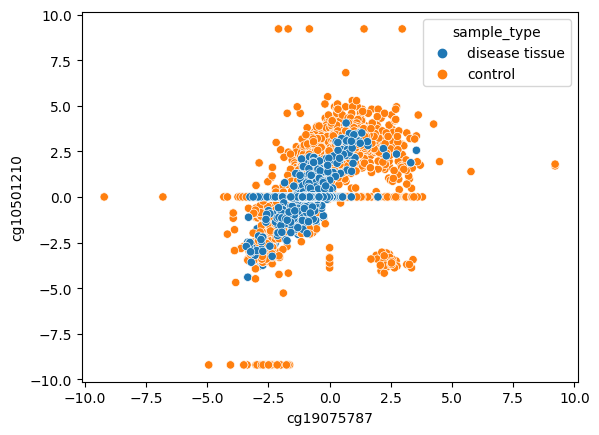

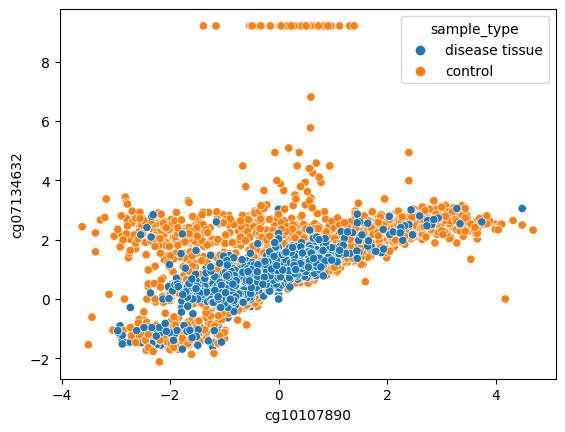

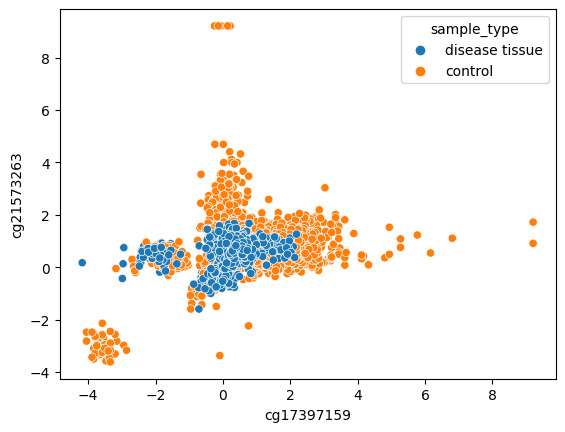

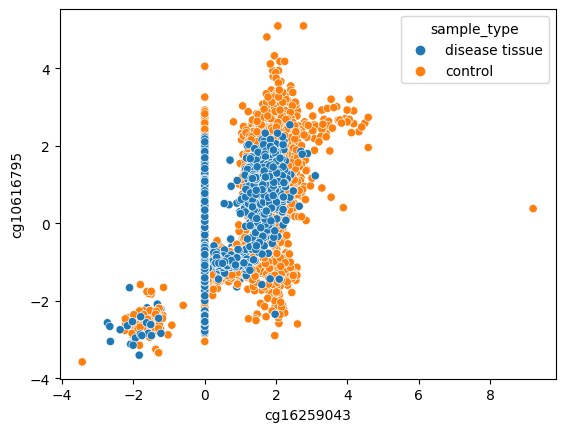

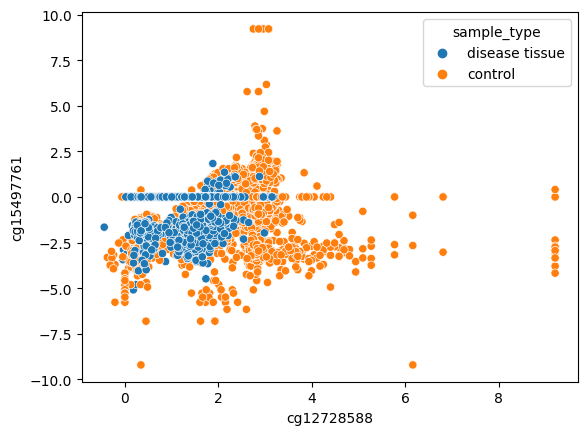

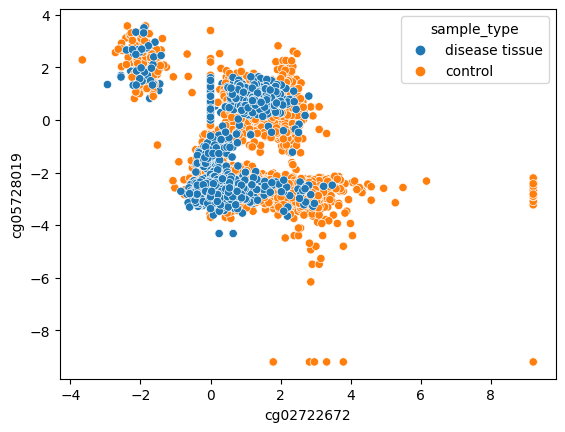

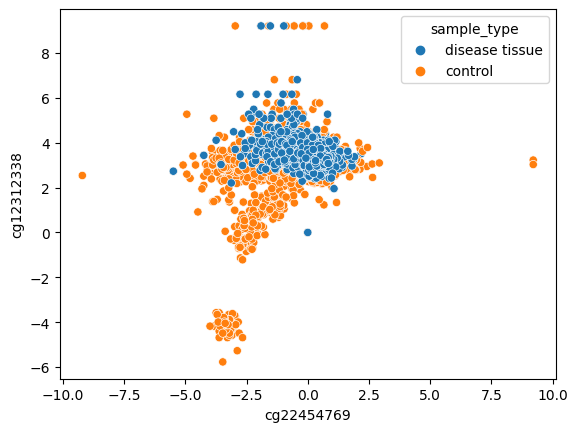

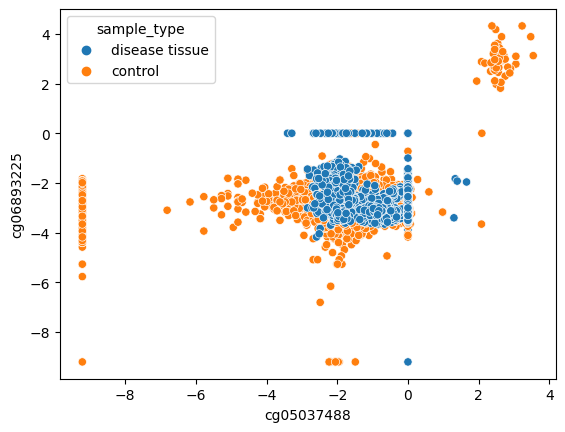

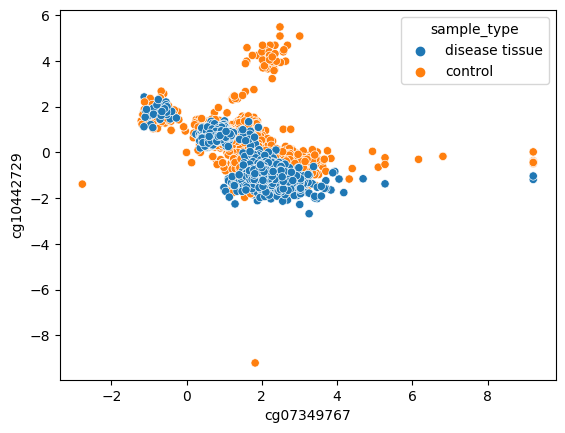

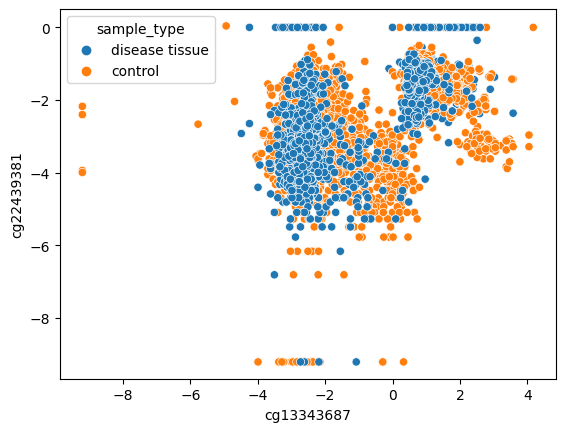

In [60]:
#绘制散点图查看数据分布
Xlabels=['cg19075787','cg10107890','cg17397159','cg16259043','cg12728588','cg02722672','cg22454769',
         'cg05037488','cg07349767','cg13343687']
Ylabels=['cg10501210','cg07134632','cg21573263','cg10616795', 'cg15497761','cg05728019','cg12312338',
       'cg06893225','cg10442729','cg22439381']
for x,y in zip(Xlabels,Ylabels):
    scatterplot=plt.figure()
    sns.scatterplot(x=x,y=y,data=traindata,hue='sample_type')
    plt.show()

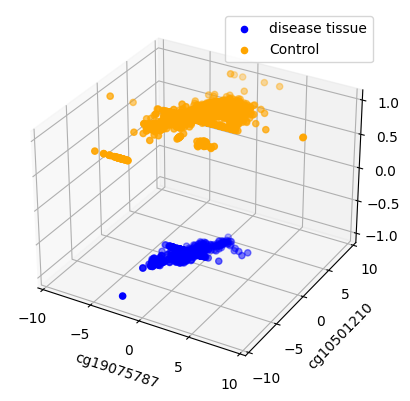

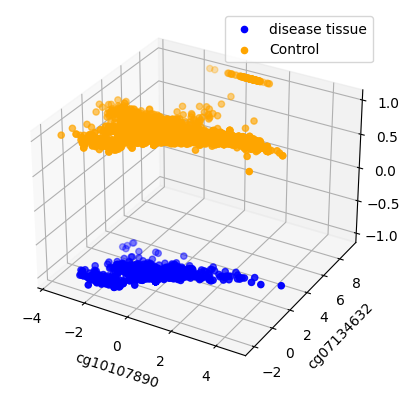

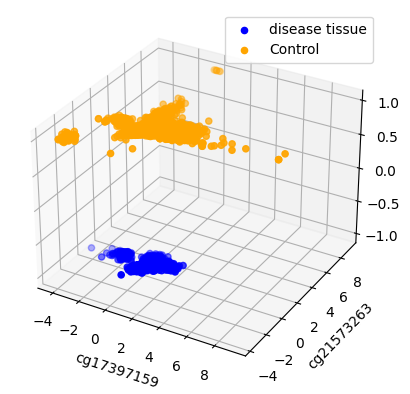

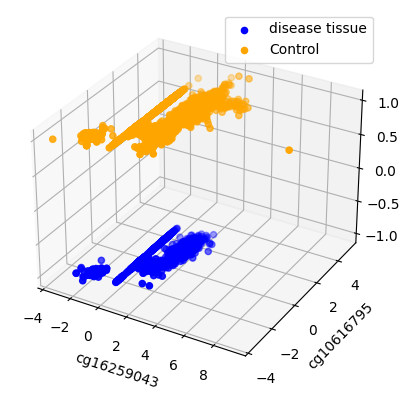

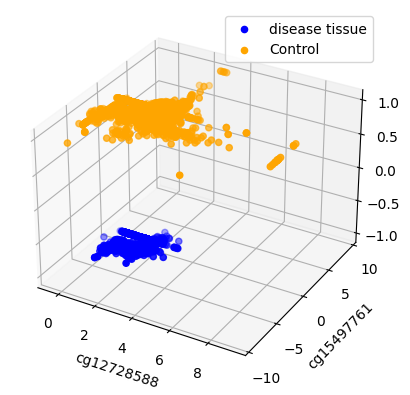

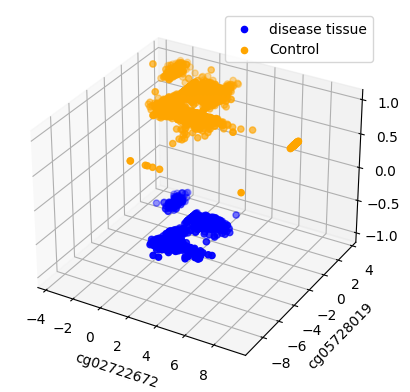

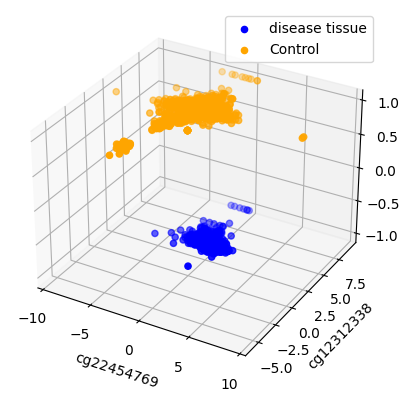

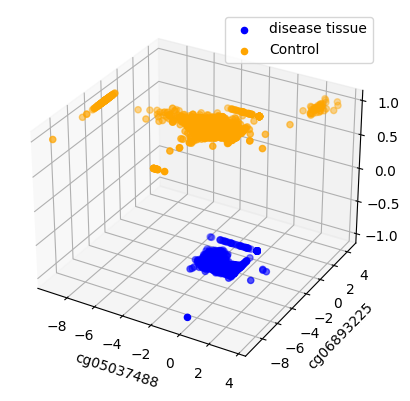

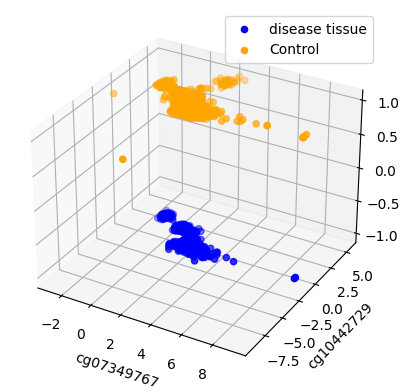

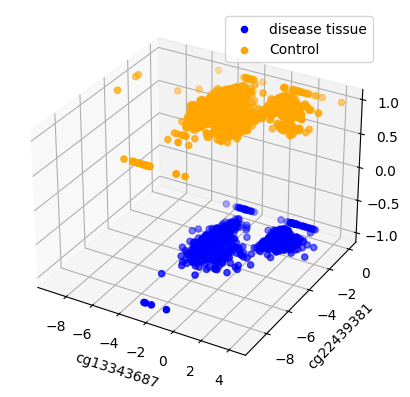

In [62]:
#拓展数据1
from mpl_toolkits.mplot3d import Axes3D
for x,y in zip(Xlabels,Ylabels):
    ScatterPlot3D=plt.figure()
    ScatterPlot3D_ax=ScatterPlot3D.add_subplot(111,projection='3d')
    ScatterPlot3D_ax.scatter(traindata.loc[traindata['sample_type_encode']==1,x],traindata.loc[traindata['sample_type_encode']==1,y],
                             -1,color='blue',label='disease tissue')    #载入患病数据
    ScatterPlot3D_ax.scatter(traindata.loc[traindata['sample_type_encode']==0,x],traindata.loc[traindata['sample_type_encode']==0,y],
                             1,color='orange',label='Control')    #载入健康数据
    ScatterPlot3D_ax.set_xlabel(x)
    ScatterPlot3D_ax.set_ylabel(y)
    plt.legend()
    plt.show()

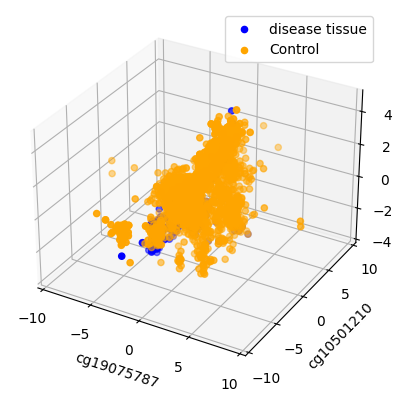

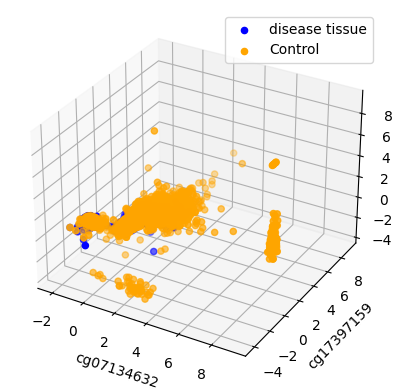

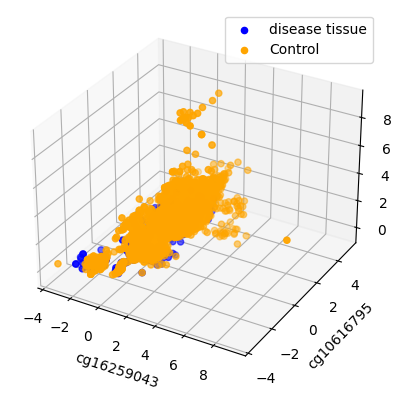

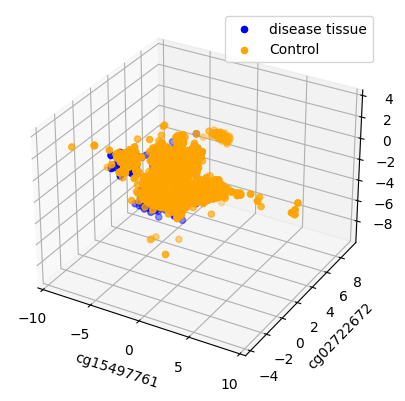

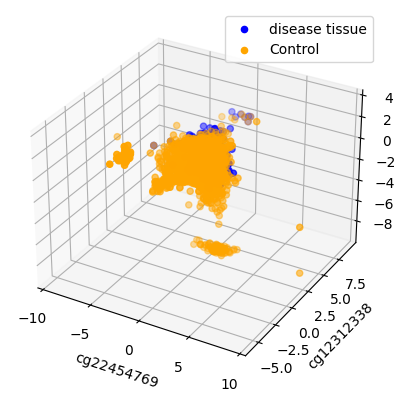

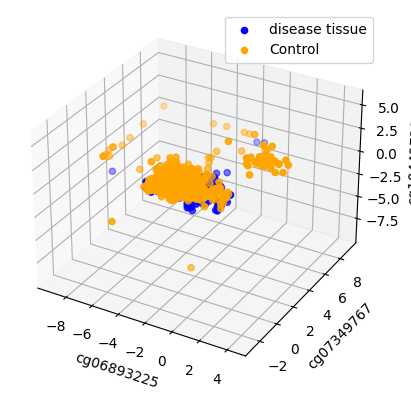

In [63]:
#绘制3D图
from mpl_toolkits.mplot3d import Axes3D
Xlabels3D=['cg19075787','cg07134632','cg16259043','cg15497761','cg22454769','cg06893225']
Ylabels3D=['cg10501210','cg17397159','cg10616795','cg02722672','cg12312338','cg07349767']
Zlabels3D=['cg10107890','cg21573263','cg12728588','cg05728019','cg05037488','cg10442729']
for x,y,z in zip(Xlabels3D,Ylabels3D,Zlabels3D):
    ScatterPlot3D=plt.figure()
    ScatterPlot3D_ax=ScatterPlot3D.add_subplot(111,projection='3d')
    ScatterPlot3D_ax.scatter(traindata.loc[traindata['sample_type_encode']==1,x],traindata.loc[traindata['sample_type_encode']==1,y],
                             traindata.loc[traindata['sample_type_encode']==1,z],color='blue',label='disease tissue')    #载入患病数据
    ScatterPlot3D_ax.scatter(traindata.loc[traindata['sample_type_encode']==0,x],traindata.loc[traindata['sample_type_encode']==0,y],
                             traindata.loc[traindata['sample_type_encode']==0,z],color='orange',label='Control')    #载入健康数据
    ScatterPlot3D_ax.set_xlabel(x)
    ScatterPlot3D_ax.set_ylabel(y)
    ScatterPlot3D_ax.set_zlabel(z)
    plt.legend()
    plt.show()

In [64]:
#读入包含正常数据的特征选择数据
DataClass=pd.read_excel('/mnt/workspace/Disease_class/Feature_Data_ClassDisease/ClassDisease_FeatureData.xlsx')
Feature_list_Mal=DataClass.columns
Feature_list_Mal=DataClass.columns[1:-6]
Feature_list_Mal

Index(['cg10501210', 'cg25149396', 'cg10818901', 'cg00687252', 'cg05839741',
       'cg00339300', 'cg18813010', 'cg13299325', 'cg21573263', 'cg00400654',
       'cg04571355', 'cg10057528', 'cg17983632', 'cg10378348', 'cg16037711',
       'cg13845951', 'cg08146977', 'cg08229522', 'cg13675050', 'cg12467852'],
      dtype='object')

In [65]:
#比较不同方法甲基化位点数据
Feature_Nomal=set(Feature_list)
Feature_mal=set(list(Feature_list_Mal))
diff=Feature_Nomal.symmetric_difference(Feature_mal)     #获取不同元素
same=Feature_Nomal.intersection(Feature_mal)    #获取相同元素
print('相同甲基化位点:',same)
print('不同甲基化位点:',diff)

相同甲基化位点: {'cg21573263', 'cg10501210'}
不同甲基化位点: {'cg18813010', 'cg15497761', 'cg13845951', 'cg00400654', 'cg08146977', 'cg16037711', 'cg07134632', 'cg10057528', 'cg00339300', 'cg04571355', 'cg05839741', 'cg17397159', 'cg12728588', 'cg25149396', 'cg12467852', 'cg02722672', 'cg00687252', 'cg10818901', 'cg22439381', 'cg22454769', 'cg13675050', 'cg10378348', 'cg19075787', 'cg06893225', 'cg13343687', 'cg12312338', 'cg08229522', 'cg10442729', 'cg10616795', 'cg13299325', 'cg10107890', 'cg05037488', 'cg17983632', 'cg07349767', 'cg16259043', 'cg05728019'}


In [66]:
#载入SVM模型
from sklearn.svm import SVC
Model_SVC=SVC(kernel='rbf',C=1,probability=False)
Model_SVC.fit(Feature_traindata,Feature_trainlabel)
Model_Evaluate(Model_SVC,Feature_traindata,Feature_trainlabel,Feature_testdata,Feature_testlabel)

模型训练准确率为:0.8027634375948983,召回率为:0.8027634375948983,f1分数为:0.8027634375948983,精度为:0.8027634375948983
模型测试准确率为:0.8032786885245902,召回率为:0.8032786885245902,f1分数为:0.8032786885245902,精度为:0.8032786885245902
模型训练误差:0.19723656240510168,测试误差:0.19672131147540983
---------------------训练数据集评估报告---------------------
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      4992
           1       0.73      0.30      0.42      1594

    accuracy                           0.80      6586
   macro avg       0.77      0.63      0.65      6586
weighted avg       0.79      0.80      0.77      6586

---------------------测试数据集评估报告---------------------
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      1274
           1       0.68      0.25      0.37       373

    accuracy                           0.80      1647
   macro avg       0.75      0.61      0.63      1647
weighted avg       0.78      0.80      0.77  